### Importing neccessary packages

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.svm import SVC
from scipy import stats
from sklearn import preprocessing

In [57]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

### Lets understand our training data

In [58]:
train_raw=pd.read_csv("train_Df64byy.csv")

In [59]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [60]:
train_raw.isna().sum() # we have missing values

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

### Here, using sql to bin the variable Holding_Policy_Duration as generally variables based on time aren't consistent as value of time increases/decreases

In [61]:
train_raw1=pysqldf('''select ID,Holding_Policy_Duration, case when Holding_Policy_Duration in ('1.0','2.0') then '1-2' when Holding_Policy_Duration in ('3.0','4.0') then '3-4' 
when Holding_Policy_Duration in ('5.0','6.0','7.0') then '5-7' 
when Holding_Policy_Duration in ('8.0','9.0','10.0','11.0','12.0','13.0','14.0') then '8-14'
else Holding_Policy_Duration end as new  from train_raw''')

In [62]:
train_raw1.new.unique() # checking for the modified values of duration field

array(['14+', None, '1-2', '3-4', '5-7', '8-14'], dtype=object)

In [63]:
train_raw=train_raw.merge(train_raw1, on = 'ID') # merging the modified field of duration back to original data

In [64]:
# just some adjustments
train_raw.rename(columns={'new':'Holding_Policy_Duration'},inplace=True)
train_raw.drop(['Holding_Policy_Duration_x','Holding_Policy_Duration_y'],axis=1,inplace=True)
train_raw.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Duration
0,1,C3,3213,Rented,Individual,36,36,No,X1,3.0,22,11628.0,0,14+
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,22,30510.0,0,None
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,19,7450.0,1,1-2
3,4,C24,4378,Owned,Joint,52,48,No,X1,3.0,19,17780.0,0,14+
4,5,C8,2190,Rented,Individual,44,44,No,X2,1.0,16,10404.0,0,3-4


In [224]:
train_raw2=pysqldf('''select ID, case when Lower_Age <21 then '<21' when Lower_Age >20 and Lower_Age <37 then '21-36' 
when Lower_Age >36 and Lower_Age <67 then '37-66' when Lower_Age = 75 then '75'
else '>66' end as lower_age_group  from train_raw''')

In [228]:
train_raw=train_raw.merge(train_raw2, on = 'ID') # merging the modified field of duration back to original data

### Marking all the Nans with Missing tag

In [65]:
cols=['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']
for k in cols:
    train_raw[k]=train_raw[k].fillna("Missing")

In [66]:
train_raw.isna().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
Response                   0
Holding_Policy_Duration    0
dtype: int64

### Okay, so we don't see any missing values anymore

### Lets see if age variables are creating any impact

<AxesSubplot:xlabel='Response', ylabel='Upper_Age'>

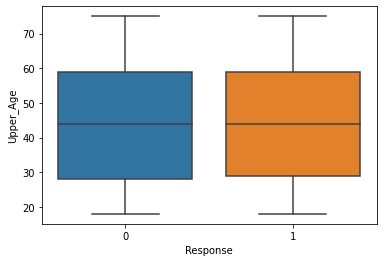

In [67]:
sns.boxplot(data=train_raw, x='Response', y='Upper_Age')

<AxesSubplot:xlabel='Response', ylabel='Lower_Age'>

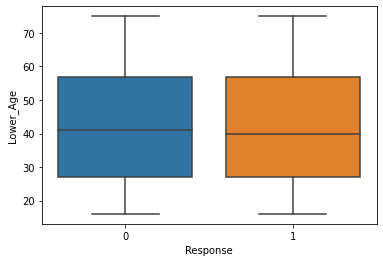

In [68]:
sns.boxplot(data=train_raw, x='Response', y='Lower_Age')

### Naah! similar variations in both the response value for the age variables

### Next, lets see if Accomodation type has any association with our Response variable

(array([0, 1]), [Text(0, 0, 'Owned'), Text(1, 0, 'Rented')])

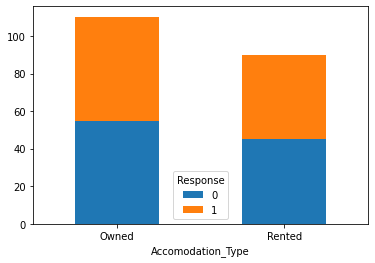

In [69]:
(pd.crosstab(index=train_raw['Accomodation_Type'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)

### Above graph do tell us that there is no association between them; lets check this hypothesis with statistical test named Chi Square test

In [70]:
contigency1= pd.crosstab(train_raw['Accomodation_Type'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigency1)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.24491793264478945


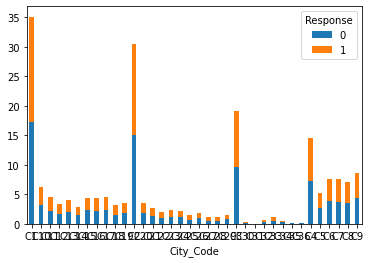

In [231]:
(pd.crosstab(index=train_raw['City_Code'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)
plt.show()

In [229]:
contigencyy= pd.crosstab(train_raw['City_Code'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigencyy)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.748625851316806


### Hooray! Above test result does support our Hypothesis! Hence, Accomodation type won't be a good predictor for Response

### Lets check now for Reco_Insurance_Type

(array([0, 1]), [Text(0, 0, 'Individual'), Text(1, 0, 'Joint')])

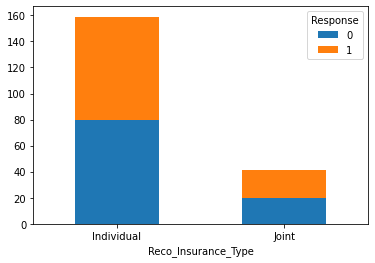

In [71]:
(pd.crosstab(index=train_raw['Reco_Insurance_Type'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)

In [72]:
contigency2= pd.crosstab(train_raw['Reco_Insurance_Type'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigency2)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.026534842934215437


### above test on Reco_Insurance_Type variable suggests that it has a significant association with Response variable

----------------------------------------------------
### Lets check now for is_spouse

(array([0, 1]), [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

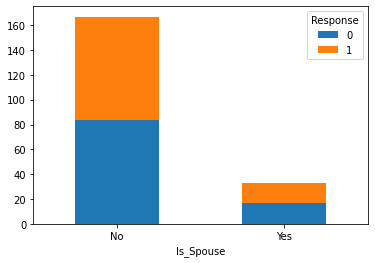

In [73]:
(pd.crosstab(index=train_raw['Is_Spouse'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)

In [74]:
contigency3= pd.crosstab(train_raw['Is_Spouse'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigency3)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.3917208801956691


### Okay! so Is_Spouse is proved to be independent of our Response variable

### Lets see our next variable, Health Indicator, if it proves to be a good predictor

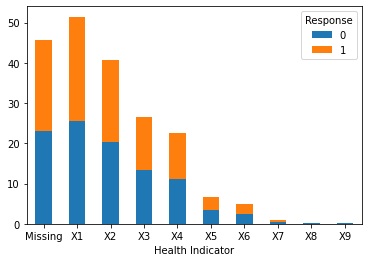

In [75]:
(pd.crosstab(index=train_raw['Health Indicator'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)
plt.show()

In [76]:
contigency4= pd.crosstab(train_raw['Health Indicator'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigency4)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.2941204137356212


### Quite surprising but Chi Sq doesn't like Health indicator variable to be featured

### Next, we will check for Holding_Policy_Duration

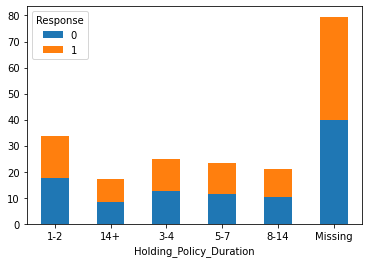

In [77]:
(pd.crosstab(index=train_raw['Holding_Policy_Duration'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)
plt.show()

In [78]:
contigency5= pd.crosstab(train_raw['Holding_Policy_Duration'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigency5)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.008216492870470517


### Above test does suggest Holding_Policy_Duration a suitable predictor for our Response variable

----------------------------------------------
### Now lets check for Holding_Policy_Type

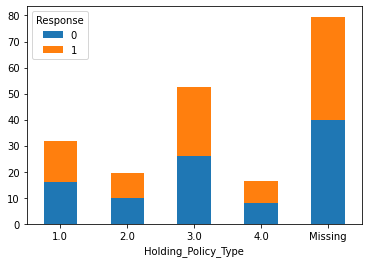

In [79]:
(pd.crosstab(index=train_raw['Holding_Policy_Type'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)
plt.show()

In [80]:
contigency6= pd.crosstab(train_raw['Holding_Policy_Type'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigency6)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.5626862404926289


### Holding_Policy_Type - not passed from Chi Sq test!

-----------------------------------------------------
### Its time for our next variable : Reco_Policy_Cat

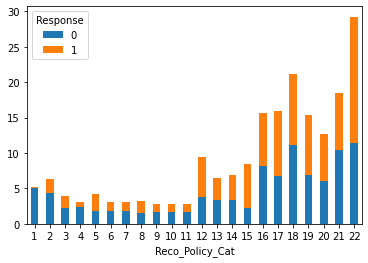

In [81]:
(pd.crosstab(index=train_raw['Reco_Policy_Cat'], columns=train_raw['Response'],normalize='columns')*100).round(2).plot(kind='bar',stacked=True)
plt.xticks(rotation=360)
plt.show()

In [82]:
contigency7= pd.crosstab(train_raw['Reco_Policy_Cat'], train_raw['Response'])
c, p, dof, expected = chi2_contingency(contigency7)
print("p value for Chi Sq test of independence ",p)

p value for Chi Sq test of independence  0.0


### Reco_Policy_Cat passed the test! Lets keep it in features for prediction.

### Now, our final variable to test, a continuous one, Reco_Policy_Premium

<AxesSubplot:xlabel='Reco_Policy_Premium', ylabel='Count'>

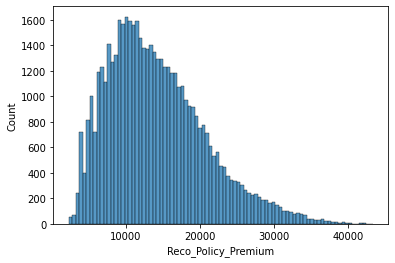

In [83]:
sns.histplot(train_raw.Reco_Policy_Premium)

<AxesSubplot:xlabel='Response', ylabel='Reco_Policy_Premium'>

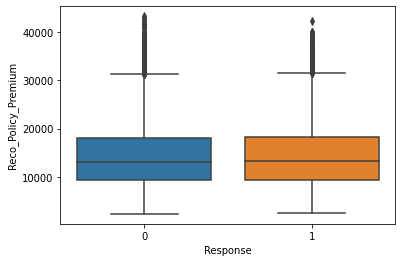

In [84]:
sns.boxplot(data=train_raw,x='Response',y='Reco_Policy_Premium')

### Above histogram and boxplot shows that data is slightly skewed towards positive side; from the above figure, lets drop the values beyond 33000; but before that validate using a formula from normal distribution : 99.7% of data should be within 3 standard deviations from central tendency

In [85]:
### calculating for Response =0
3*np.std(train_raw.Reco_Policy_Premium[train_raw.Response==0]) + np.median(train_raw.Reco_Policy_Premium[train_raw.Response==0])

32894.1424810469

In [86]:
### calculating for Response =1
3*np.std(train_raw.Reco_Policy_Premium[train_raw.Response==1]) + np.median(train_raw.Reco_Policy_Premium[train_raw.Response==1])

33097.67939866938

### lets find out , how many records we might lose

In [87]:
len(train_raw[train_raw.Reco_Policy_Premium > 33000])

512

### 512 is quite a small fraction of entire data ; we can drop these

In [88]:
train_raw=train_raw[train_raw.Reco_Policy_Premium < 33000].reset_index()

### Now, lets do a T - test of independece as Reco_Policy_Premium is a continuous variable

#### but..... hold on! T test can be only applied if the variable follows a normal distribution ; Lets test the nomality!


In [51]:
stats.normaltest(train_raw.Reco_Policy_Premium)

NormaltestResult(statistic=2747.536291462379, pvalue=0.0)

####  from above, p value suggests that variable Reco_Policy_Premium is not normally distributed

### Still, lets violate normality assumption and check the p value using t test

In [89]:
ttest_ind(train_raw.Reco_Policy_Premium[train_raw.Response == 0],train_raw.Reco_Policy_Premium[train_raw.Response == 1]).pvalue

0.07624293696921038

In [97]:
print("Standard Deviation for Reco_Policy_Premium :",np.std(train_raw.Reco_Policy_Premium))

Standard Deviation for Reco_Policy_Premium : 6260.426870716738


### Above test for variable Reco_Policy_Premium slightly fail for 95% confidence, but can be passed for 93% confidence ; however, it failed to meet normal assumption but a higher standard deviation along with some business sense is supporting  this variable to get featured! 


--------------------------------------------------------------
## So, finally selected features for modelling are :
## Reco_Insurance_Type, Holding_Policy_Duration, Reco_Policy_Cat & Reco_Policy_Premium

In [183]:
df= train_raw[['ID','Health Indicator','Lower_Age','Response','Reco_Insurance_Type','Holding_Policy_Duration','Reco_Policy_Cat','Reco_Policy_Premium']]
df.set_index('ID',inplace=True)
df.rename(columns={'Health Indicator':'Health_Indicator'},inplace=True)

C:\Users\sgupt\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [184]:
df_0=df[df.Response==0]
df_1=df[df.Response==1]

In [185]:
print("% of class 0 in Target variable ",len(df_0)/(len(df_0)+len(df_1)))
print("% of class 1 in Target variable",len(df_1)/(len(df_0)+len(df_1)))

% of class 0 in Target variable  0.7601151479054993
% of class 1 in Target variable 0.2398848520945007


### We can see that data is imbalanced, so lets create a balanced dataset to train records using downsampling

In [186]:
df_0_downsampled=resample(df_0,replace=False, n_samples=7000,random_state=2)
df_1_downsampled=resample(df_1,replace=False, n_samples=5000,random_state=2)
df_downsample=pd.concat([df_0_downsampled,df_1_downsampled])

In [204]:
X=df_downsample.drop('Response',axis=1).copy()
y=df_downsample['Response'].copy()

### We need to generate encoded values for object type variables

In [209]:
for f in X.columns:
    if X[f].dtype=='object':
#         print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values))
        X[f] = lbl.transform(list(X[f].values))

In [188]:
# X=pd.get_dummies(X,['Health_Indicator','Reco_Insurance_Type','Holding_Policy_Duration'])

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

### Importing modules for model training

In [141]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

### Since Decision tree tend to overfit most often, hence finding the best parameters using GridSearchCV

In [223]:
# define parameters for Decison trees
max_depth_range=np.linspace(3,21,3,0)
tree_param = [{'criterion': ['entropy', 'gini'], 'max_depth': max_depth_range},
              ]
clf = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=10)
clf.fit(X_train,y_train).best_params_

{'criterion': 'entropy', 'max_depth': 9.0}

In [221]:
clf_tuned=DecisionTreeClassifier(criterion='entropy',max_depth=9)
clf_tuned.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [222]:
preds=clf_tuned.predict_proba(X_test)[:,1]
print("roc_auc score : ",roc_auc_score(y_test,preds))

roc_auc score :  0.6056340571428571


### Lets create another test sample from original imbalanced data and check our model performance

In [201]:
new_test=resample(df,replace=False, n_samples=2000,random_state=2)
Xn=new_test.drop('Response',axis=1).copy()
yn=new_test['Response'].copy()

In [202]:
Xn=pd.get_dummies(Xn,['Reco_Insurance_Type','Health_Indicator','Holding_Policy_Duration'])

In [203]:
preds_n=clf_tuned.predict_proba(Xn)[:,1]
print("roc_auc score : ",roc_auc_score(yn,preds_n))

roc_auc score :  0.6201520985752791


In [ ]:
for i in range(50):

## With Decision Trees classifier, roc_auc score achieved isn't very competitive ; however the model can be interpreted using graphviz feature.
Note : This notebook contained EDA,feature engineering and a baseline classifier model preserving interpretation. However, the hackathon predictions are generated using XGBoost model (a blackbox model) (demonstrated in a separate notebook) to achieve higher scores.

                                        ------ Thank You ------